In [2]:
from fibheap import FibonacciHeap as FibHeap
import networkx as nx
import copy
import matplotlib.pyplot as plt
import matplotlib
# from dsd import exact_densest
from bigclam import *
import math
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [42]:
def create_flow_network_from_graph(G, m, query, weighted):
#     m = G.number_of_edges()
    G = nx.DiGraph(G)
    H = G.copy()
    H.add_node('s')
    H.add_node('t')
    for e in G.edges():
        H.add_edge(e[0], e[1], capacity=(1 if not weighted else G[e[0]][e[1]]['weight']))

    for v in G.nodes():
        H.add_edge('s', v, capacity=m)
        H.add_edge(v, 't', capacity=m + 2 * query - G.in_degree(v, weight=(None if not weighted else 'weight')))
    return H

def exact_densest_from_graph1(G: nx.Graph, weighted=False):
#     check_undirected_graph(G)
    if weighted:
        m = G.size('weight')
    else:
        m = G.number_of_edges()
    n = G.number_of_nodes()
    minD = m / n  # rho^* >= m/n since V is a feasible solution
    maxD = (n - 1) / 2

    opt = 0
    Sstar = G.nodes()
    if minD == maxD:
        return Sstar, maxD
    while maxD - minD > 1 / n ** 2:  # binary search
        query = (maxD + minD) / 2
        # print('Query value is ',query )
        H = create_flow_network_from_graph(G, m, query, weighted)
        solution = nx.minimum_cut(H, 's', 't', capacity='capacity')  # unspecified behavior
        #         print(solution[0])
        cut = solution[1][0]
        #         print(cut)
        if cut == {'s'}:
            maxD = query  # this means there is no subgraph S such that the degree density is at least query
        else:
            #             print('Found denser subgraph!')
            minD = query
            Sstar = cut
            opt = query
    Sstar = list(set(Sstar)&set(G.nodes()))
    return Sstar, opt

In [75]:

def finland(G, c, k, T, debug):
    mat = []
    adj = nx.adjacency_matrix(G).todense()
    n = G.number_of_nodes()
    W = n*(n-1)/2/G.number_of_edges()
    zero_idx = np.where(adj==0)
    one_idx = np.where(adj>0)
    for i in G.nodes():
        vec = []
        for j in range(k):
            vec.append(random.randint(0,1))
        mat.append(vec)
    mat = np.array(mat)

    adj_h = np.where(np.matmul(mat, mat.T) > 0.5, 1, 0)
    np.fill_diagonal(adj_h, 0)
    cur_h = len(np.where(adj_h[zero_idx]==0)[0])+W*(len(np.where(adj_h[one_idx]==1)[0]))
    steady = 0
    for i in range(T):
        if steady>20:
            break
        tmp_n = random.randint(0,G.number_of_nodes()-1)
        vec = []
        for j in range(k):
            vec.append(random.randint(0,1))

        new_mat = np.array(mat)
        new_mat[tmp_n,:]=vec
        adj_new = np.where(np.matmul(new_mat, new_mat.T) > 0.5, 1, 0)
        np.fill_diagonal(adj_new, 0)
        new_h = len(np.where(adj_new[zero_idx]==0)[0])+W*(len(np.where(adj_new[one_idx]==1)[0]))
        steady += 1
        if debug:
            print('iteration', i, 'choose node', tmp_n)
            print('current mat')
            print(mat)
            print('proposed new vec', vec, mat[tmp_n,:])
            print(adj_h[tmp_n,:], adj_new[tmp_n,:])
            print(len(np.where(adj_h[zero_idx]==0)[0]))
            print(len(np.where(adj_new[zero_idx]==0)[0]))
            print('cur and pre diff', new_h, cur_h)
        if random.uniform(0,1)<math.exp(c*(new_h-cur_h)):
            if debug:
                print('change!')
            mat = new_mat
            cur_h = new_h
            adj_h = adj_new
            steady = 0
        if debug and i>10:
            break
    print('finished running after', i, 'iterations')
    return mat

# finland(G, c, k, T, False)

In [46]:


def init_heap_flowless_from_graph(G, found_set, lambd=1, weight=None):
    node_dict = dict()
    fibheap = FibHeap()
#     print(found_set)
    total_degree = 0
    if len(found_set)>0:
        tmp_pen = (2*len(found_set))/len(found_set)
    else:
        tmp_pen = 0
    for node in G.nodes():
        node_dict[node] = (list(), fibheap.insert(0, node))
        for neighbor in G[node]:
            if weight is None:
                edge_w = 1
            else:
                edge_w = G[node][neighbor][weight]
            fibheap.decrease_key(node_dict[node][1], node_dict[node][1].key + edge_w)
            node_dict[node][0].append(neighbor)
            total_degree += edge_w
        if len(found_set)>0 and node in found_set:
            fibheap.decrease_key(node_dict[node][1], node_dict[node][1].key - lambd*tmp_pen)
#             total_degree -= lambd*tmp_pen
    total_weight = total_degree / 2

#     for node in loads:
#         fibheap.decrease_key(node_dict[node][1], node_dict[node][1].key + loads[node])

    return node_dict, fibheap, total_weight


def greedy_helper_from_graph(G, node_dict, fib_heap, total_degree, found_set, lambd=1, weight=None,quasi_clique=False, alpha=0.33):
    n = G.number_of_nodes()
    if quasi_clique:
        obj = total_degree-alpha*n*(n-1)/2 - lambd*(len(found_set)/n)
    else:
        obj = (total_degree / n) - lambd*(len(found_set)/n)
    H = list(G)
    max_obj = obj
    intersect = len(found_set)
    for i in range(n - 1):
        # find min node from graph (remove from heap)
        to_remove = fib_heap.extract_min()
        node_to_remove = to_remove.value
#         degree_to_remove = to_remove.key
#         new_loads[node_to_remove] = degree_to_remove

        # for every neighbor node this min node have
        for neighbor in node_dict[node_to_remove][0]:
            edge_w = 1 if weight is None else G[node_to_remove][neighbor][weight]

            # here the key can be actually increased
            if neighbor != node_to_remove:
                fib_heap.decrease_key(node_dict[neighbor][1], node_dict[neighbor][1].key - edge_w)
                node_dict[neighbor][0].remove(node_to_remove)
            total_degree -= edge_w
        
        del node_dict[node_to_remove]
        if len(found_set)>0 and (node_to_remove in found_set):
            intersect -= 1
            change = lambd*2/len(found_set)
            for j in range(n):
                if j in node_dict and j in found_set:
                    fib_heap.decrease_key(node_dict[j][1], node_dict[j][1].key + change)
        if quasi_clique:
            obj = total_degree-alpha*(n - i - 1)*(n - i - 2)/2
        else:
            obj = (total_degree / (n - i - 1))
        if len(found_set)>0:
            obj -= lambd*(intersect**2/len(found_set)/(n - i - 1))
        if max_obj < obj:
            max_obj = obj
            H = list(node_dict.keys())
#     print(total_degree,'!!')
    return H, max_obj

def flowless_from_graph(G, T, lambd=1, weight=None, quasi_clique=False, alpha=0.33, init_max_flow=True, weighted=False):
    found_set = set()
    result = []
#     H = copy.deepcopy(G)
#     Hstar = H
    for i in range(T):
        if i==0 and init_max_flow:
            H = exact_densest_from_graph1(G, weighted)[0]
        else:
            node_dict, fibheap, total_degree = init_heap_flowless_from_graph(G, found_set, lambd, weight=weight)
            H, tmp = greedy_helper_from_graph(G, node_dict, fibheap, total_degree, found_set, lambd, weight=weight, quasi_clique=quasi_clique, alpha=alpha)
        found_set = (found_set | set(H))
        result.append(H)
        # print('iteration ' + repr(i + 1))
#         if tmp > rhostar:
#             rhostar = tmp
#             Hstar = H
#             loadsstar = loads
    return result, found_set

## Graph model

Unweighted Graph G contains n nodes and some background edge probability $\epsilon$, two overlapping communities are planted as follows. Community 1 $S_1$ contains n1+n3 nodes, with edge probability p, Community 2 $S_2$ contains n2+n3 nodes, with edge probability q, two communities have n3 common nodes.

If n1=n2, and $p/q=\beta$, $n_1/n_3=\alpha$. The expected density of $S_1$ is greater than $S_1\cup S_2$ only when $\beta >{(1+\alpha)^3-(2-p)\alpha - 1\over \alpha (1+\alpha)^2}$.

In [4]:
import random

# Synthetic graph
def generate_edges(G, start, end, p, weighted=False):
    edges = []
    for i in range(start, end):
        for j in range(i+1,end+1):
            if random.uniform(0,1)<p:
                if not weighted or j not in G[i]:
                    G.add_edge(i,j,weight=1)
                else:
                    G[i][j]['weight'] += 1

def syn_graph(n, n1, n2_start, n2_end, p, q, background, weighted=None):
    G = nx.Graph()
    G.add_nodes_from([i for i in range(n)])
    generate_edges(G,0,n-1,background, weighted)
    generate_edges(G,0,n1,p, weighted)
    generate_edges(G,n2_start,n2_end,q, weighted)
    return G

## unweighted version. Left: BigClam, mid: 2 times overlapping DSD, right: FINland. Nodes cannot be clasified by a method are marked red.

### Sparse graphs.

with p=0.2 and q= 0.1
overlapping size: 26


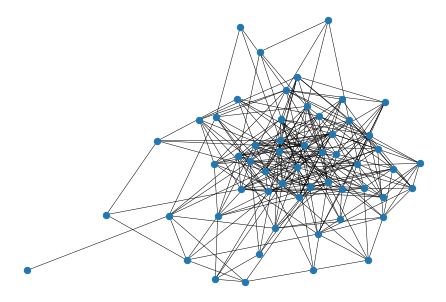

finished running after 898 iterations


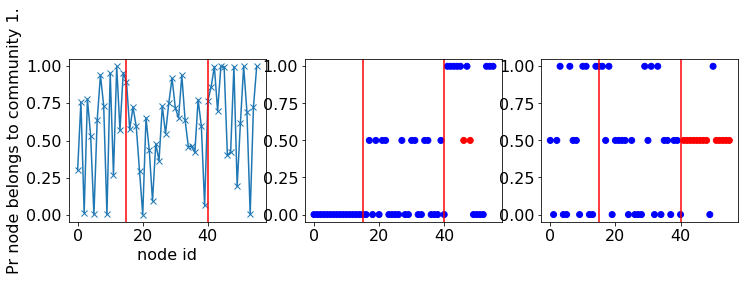

overlapping size: 1


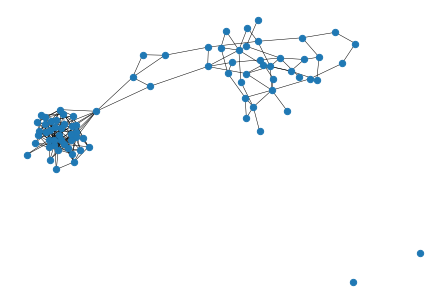

finished running after 999 iterations


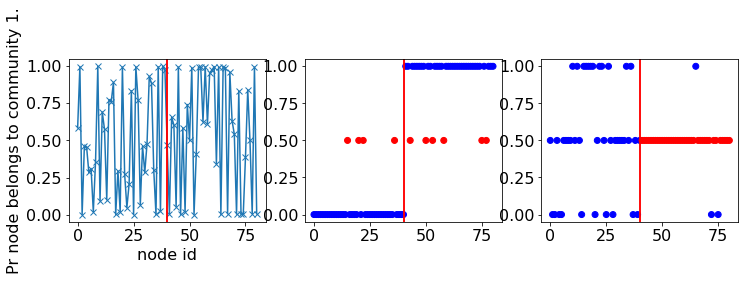

with p=0.2 and q= 0.2
overlapping size: 26


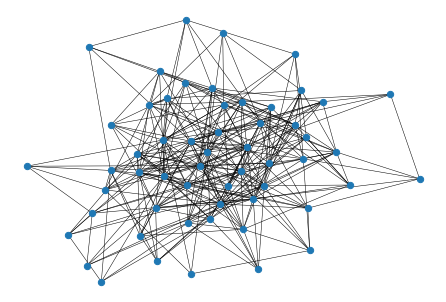

finished running after 999 iterations


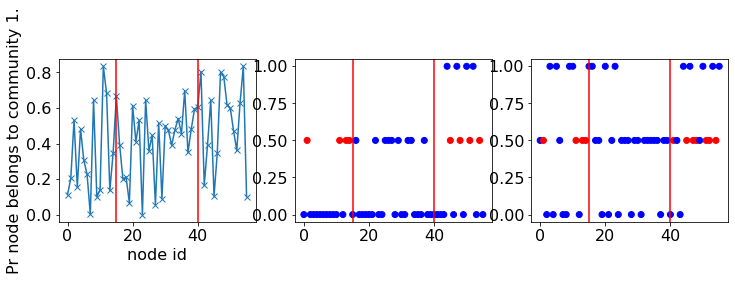

overlapping size: 1


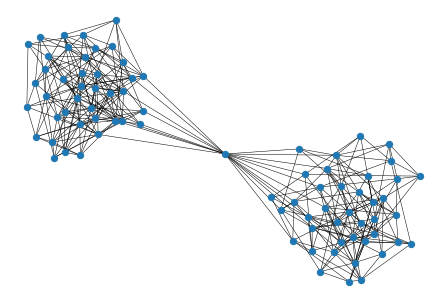

finished running after 999 iterations


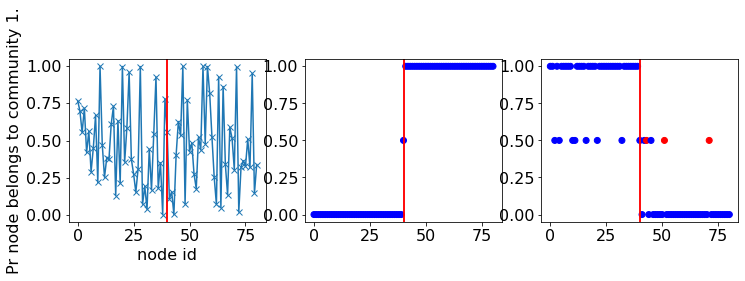

with p=0.2 and q= 0.4
overlapping size: 26


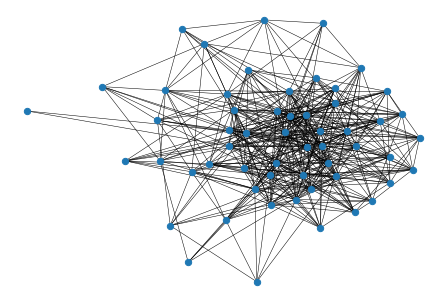

finished running after 999 iterations


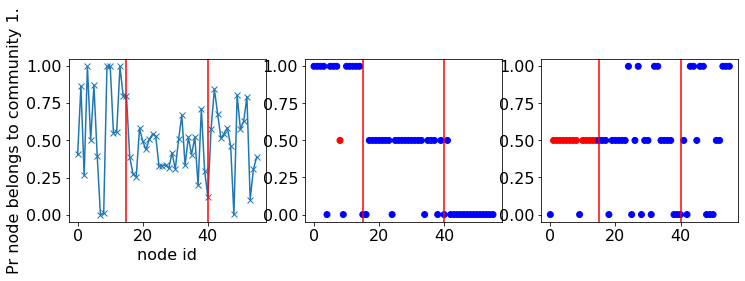

overlapping size: 1


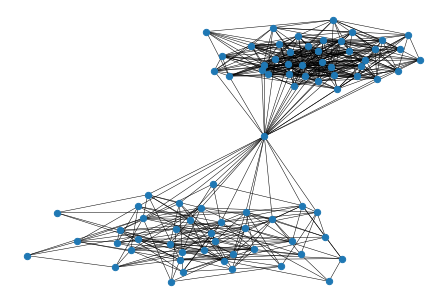

finished running after 999 iterations


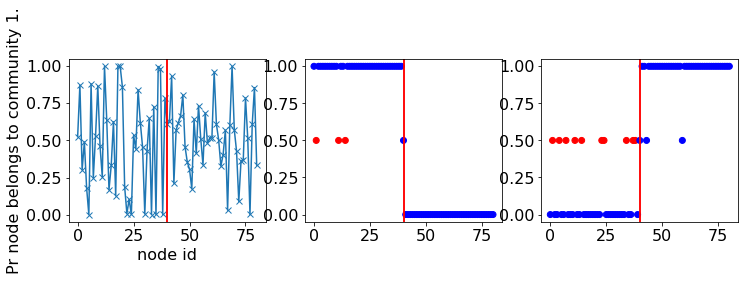

In [11]:

for q in [0.1,0.2,0.4]:
    print('with p=0.2 and q=',q)
    for start in [15, 40]:
        print('overlapping size:', 41-start)
        G = syn_graph(start+41,40,start,start+40,0.2,q,0)
        nx.draw(G, node_size=40, width=0.5)
        plt.show()
        adj = nx.adjacency_matrix(G).todense()
        F = train(adj, 2, 1000)
        F_argmax = np.argmax(F,1)
        sum_of_rows = F.sum(axis=1)
        F = F / sum_of_rows[:, np.newaxis]
        plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.plot(F[:,0], marker='x')
        plt.axvline(x=start,color='r')
        plt.axvline(x=40,color='r')
        plt.xlabel('node id')
        plt.ylabel('Pr node belongs to community 1.')
#         plt.show()
        
        lambd = 8
        result, found_set = flowless_from_graph(G, 2, lambd=lambd)
        ys = []
        color = []
        for i in range(start+41):
            tmp_c = 'b'
            if i in result[0]:
                if i in result[1]:
                    ys.append(0.5)
                else:
                    ys.append(0)
            elif i in result[1]:
                ys.append(1)
            else:
                ys.append(0.5)
                tmp_c = 'r'
            color.append(tmp_c)
        plt.subplot(132)
        plt.scatter([i for i in range(start+41)], ys, c=color)
        plt.axvline(x=start,color='r')
        plt.axvline(x=40,color='r')
        
        mat = finland(G, 0.25, 2, 1000, False)
        ys = []
        color = []
        for i in mat:
            if i[0]==i[1]:
                ys.append(0.5)
                if i[0]==0:
                    color.append('r')
                else:
                    color.append('b')
            else:
                ys.append(i[0])
                color.append('b')
        plt.subplot(133)
        plt.scatter([i for i in range(start+41)], ys, c=color)
        plt.axvline(x=start,color='r')
        plt.axvline(x=40,color='r')
        plt.show()

### dense graphs

with p=0.5 and q= 0.6
overlapping size: 21
13.950819672131148 13.195121951219512


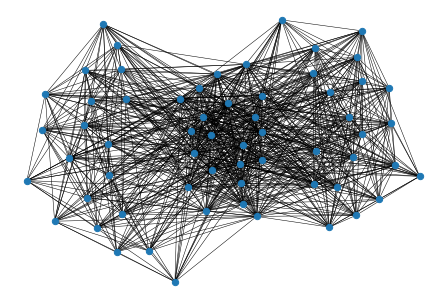

lambda= 15
finished running after 999 iterations


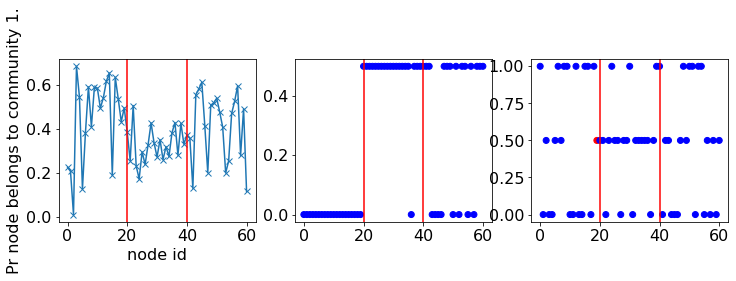

overlapping size: 1
11.08641975308642 12.0


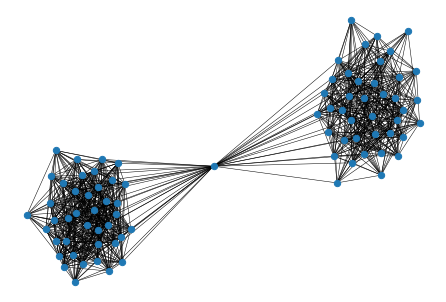

lambda= 15
finished running after 999 iterations


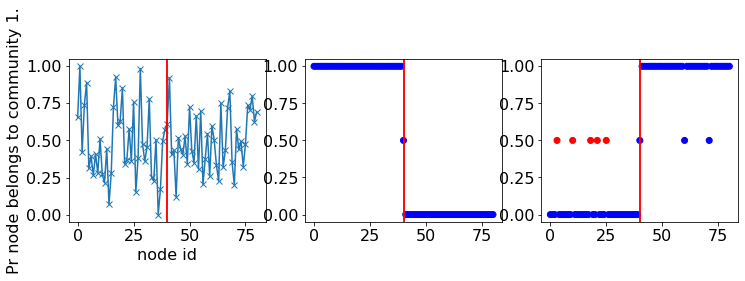

with p=0.5 and q= 0.8
overlapping size: 21
15.80327868852459 16.341463414634145


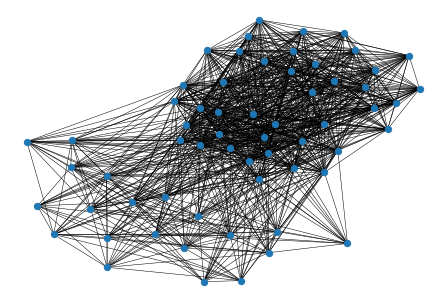

lambda= 15
finished running after 999 iterations


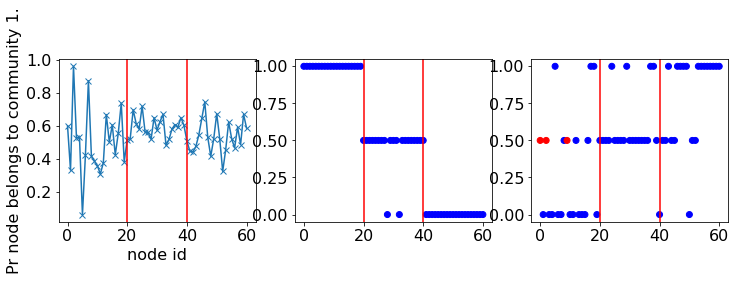

overlapping size: 1
13.234567901234568 16.073170731707318


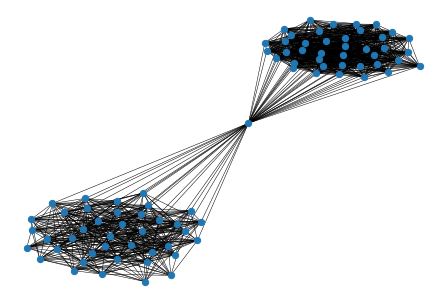

lambda= 15
finished running after 999 iterations


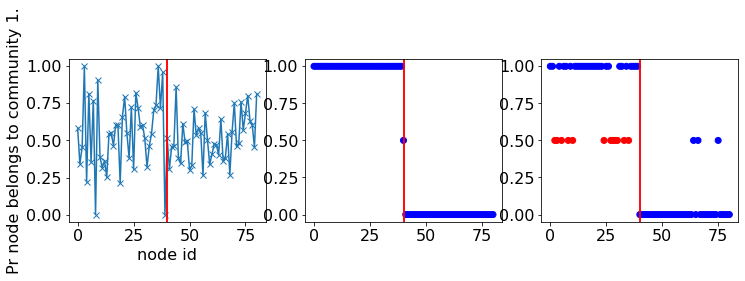

In [74]:

for q in [0.6,0.8]:
    print('with p=0.5 and q=',q)
    for start in [20,40]:
        for lambd in [15]:
            print('overlapping size:', 41-start)
            G = syn_graph(start+41,40,start,start+40,0.5,q,0)
            sub = G.subgraph([i for i in range(start, start+41)])
            print(G.size()/G.number_of_nodes(), sub.size()/sub.number_of_nodes())
            nx.draw(G, node_size=40, width=0.5)
            plt.show()
            adj = nx.adjacency_matrix(G).todense()
            F = train(adj, 2, 1000)
            F_argmax = np.argmax(F,1)
            sum_of_rows = F.sum(axis=1)
            F = F / sum_of_rows[:, np.newaxis]
            plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.plot(F[:,0], marker='x')
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')
            plt.xlabel('node id')
            plt.ylabel('Pr node belongs to community 1.')
    #         plt.show()

    #         lambd = 3
            print('lambda=', lambd)
            result, found_set = flowless_from_graph(G, 2, lambd=lambd)
            ys = []
            color = []
            for i in range(start+41):
                tmp_c = 'b'
                if i in result[0]:
                    if i in result[1]:
                        ys.append(0.5)
                    else:
                        ys.append(0)
                elif i in result[1]:
                    ys.append(1)
                else:
                    ys.append(0.5)
                    tmp_c = 'r'
                color.append(tmp_c)
            plt.subplot(132)
            plt.scatter([i for i in range(start+41)], ys, c=color)
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')

            mat = finland(G, 0.05, 2, 1000, False)
            ys = []
            color = []
            for i in mat:
                if i[0]==i[1]:
                    ys.append(0.5)
                    if i[0]==0:
                        color.append('r')
                    else:
                        color.append('b')
                else:
                    ys.append(i[0])
                    color.append('b')
            plt.subplot(133)
            plt.scatter([i for i in range(start+41)], ys, c=color)
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')
            plt.show()

## weighted(multigraph) version: left BigClam, mid 2 times overlapping DSD, right FINland (if displayed).

### sparse graphs

with p=0.2 and q= 0.1
overlapping size: 26


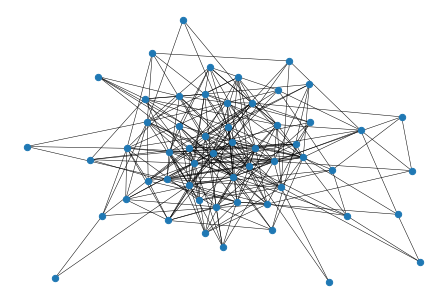

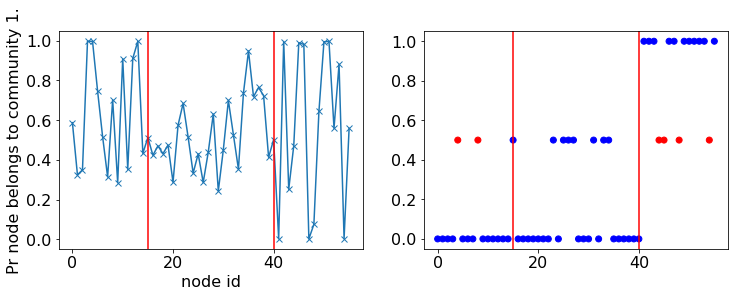

overlapping size: 1


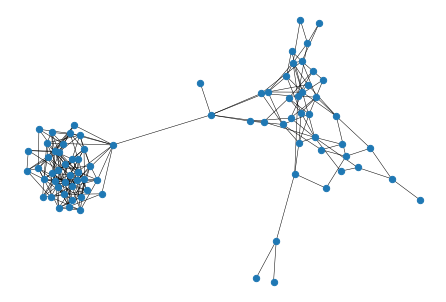

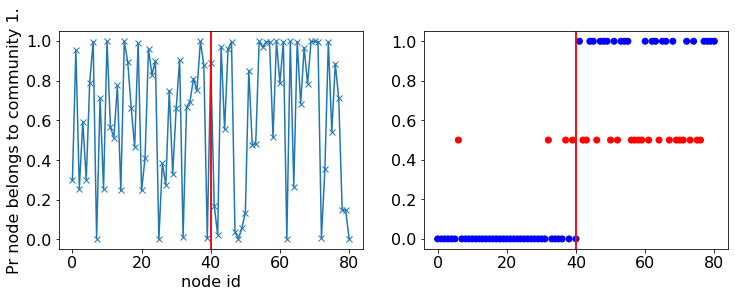

with p=0.2 and q= 0.2
overlapping size: 26


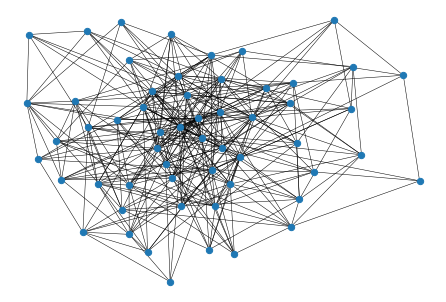

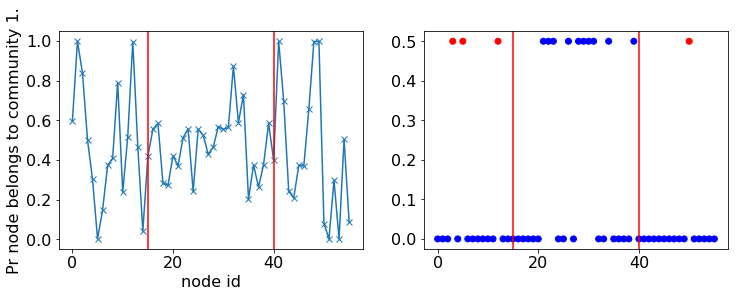

overlapping size: 1


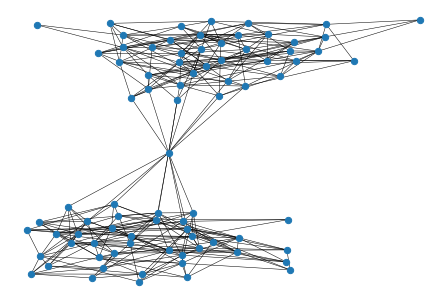

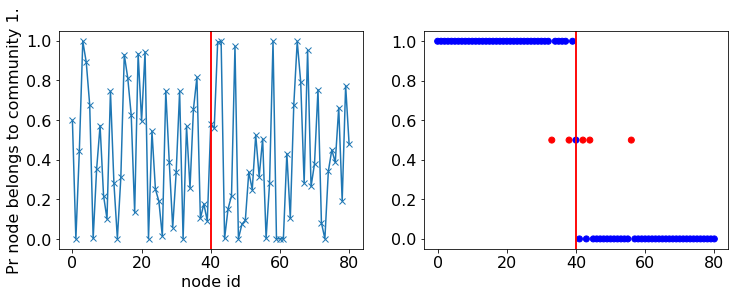

with p=0.2 and q= 0.4
overlapping size: 26


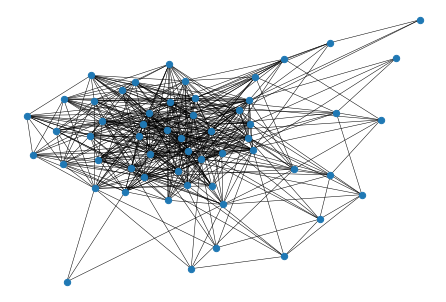

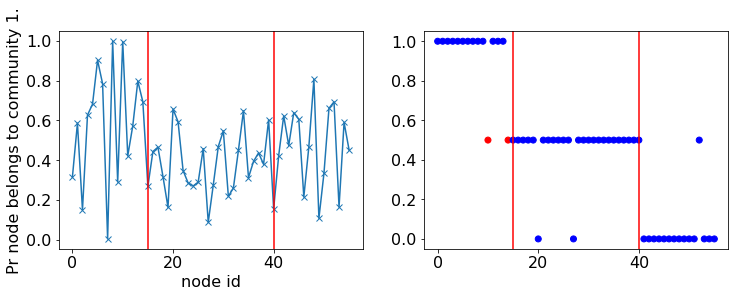

overlapping size: 1


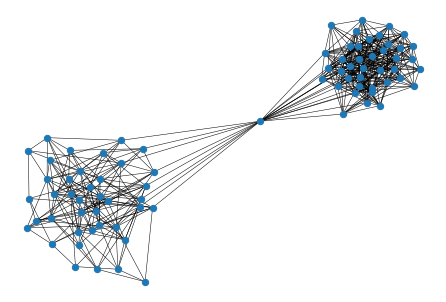

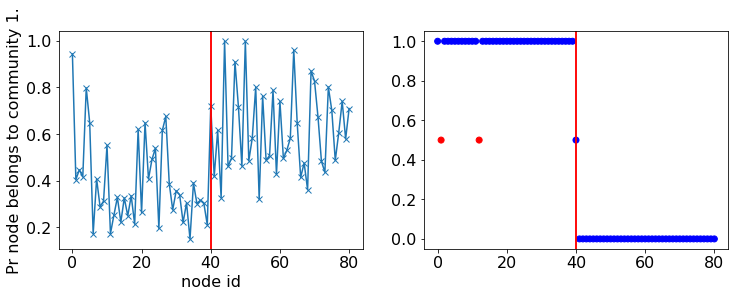

In [26]:

for q in [0.1,0.2,0.4]:
    print('with p=0.2 and q=',q)
    for start in [15, 40]:
        print('overlapping size:', 41-start)
        G = syn_graph(start+41,40,start,start+40,0.2,q,0, weighted=True)
        nx.draw(G, node_size=40, width=0.5)
        plt.show()
        adj = nx.adjacency_matrix(G).todense()
        F = train(adj, 2, 1000)
        F_argmax = np.argmax(F,1)
        sum_of_rows = F.sum(axis=1)
        F = F / sum_of_rows[:, np.newaxis]
        plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.plot(F[:,0], marker='x')
        plt.axvline(x=start,color='r')
        plt.axvline(x=40,color='r')
        plt.xlabel('node id')
        plt.ylabel('Pr node belongs to community 1.')
#         plt.show()
        
        lambd = 8
        result, found_set = flowless_from_graph(G, 2, lambd=lambd, weight='weight')
        ys = []
        color = []
        for i in range(start+41):
            tmp_c = 'b'
            if i in result[0]:
                if i in result[1]:
                    ys.append(0.5)
                else:
                    ys.append(0)
            elif i in result[1]:
                ys.append(1)
            else:
                ys.append(0.5)
                tmp_c = 'r'
            color.append(tmp_c)
        plt.subplot(122)
        plt.scatter([i for i in range(start+41)], ys, c=color)
        plt.axvline(x=start,color='r')
        plt.axvline(x=40,color='r')
        plt.show()

### dense graphs

with p=0.5 and q= 0.7
overlapping size: 26
17.178571428571427 17.48780487804878


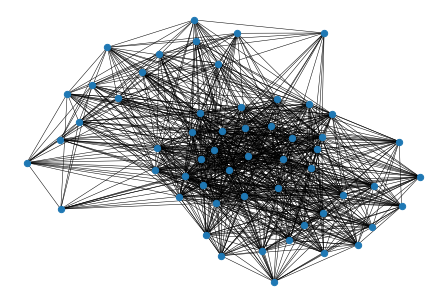

lambda= 15
finished running after 999 iterations


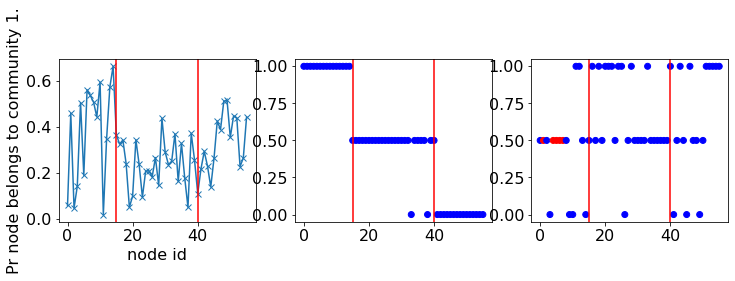

with p=0.5 and q= 0.8
overlapping size: 26
18.821428571428573 19.975609756097562


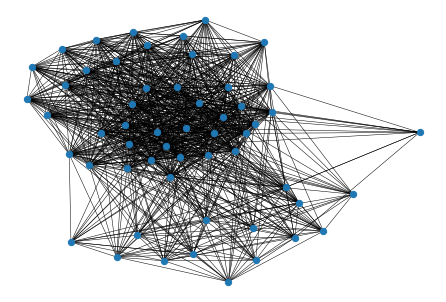

lambda= 15
finished running after 999 iterations


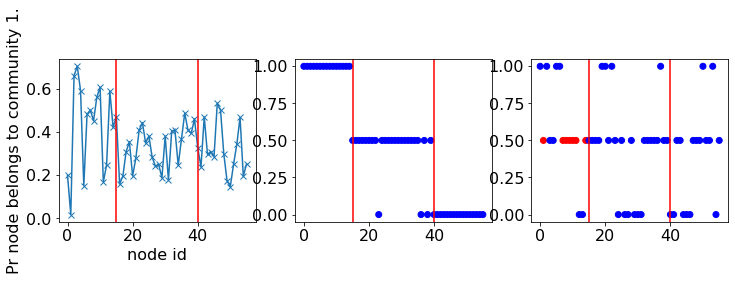

In [76]:

for q in [0.7,0.8]:
    print('with p=0.5 and q=',q)
    for start in [15]:
        print('overlapping size:', 41-start)
        G = syn_graph(start+41,40,start,start+40,0.5,q,0, weighted=True)
        sub = G.subgraph([i for i in range(start, start+41)])
        print(G.size(weight='weight')/G.number_of_nodes(), sub.size(weight='weight')/sub.number_of_nodes())
        nx.draw(G, node_size=40, width=0.5)
        plt.show()
        for lambd in [15]:
            
            adj = nx.adjacency_matrix(G).todense()
            F = train(adj, 2, 1000)
            F_argmax = np.argmax(F,1)
            sum_of_rows = F.sum(axis=1)
            F = F / sum_of_rows[:, np.newaxis]
            plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.plot(F[:,0], marker='x')
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')
            plt.xlabel('node id')
            plt.ylabel('Pr node belongs to community 1.')
    #         plt.show()

    #         lambd = 3
            print('lambda=', lambd)
            result, found_set = flowless_from_graph(G, 2, lambd=lambd, weighted=True)
            ys = []
            color = []
            for i in range(start+41):
                tmp_c = 'b'
                if i in result[0]:
                    if i in result[1]:
                        ys.append(0.5)
                    else:
                        ys.append(0)
                elif i in result[1]:
                    ys.append(1)
                else:
                    ys.append(0.5)
                    tmp_c = 'r'
                color.append(tmp_c)
            plt.subplot(132)
            plt.scatter([i for i in range(start+41)], ys, c=color)
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')

            mat = finland(G, 0.05, 2, 1000, False)
            ys = []
            color = []
            for i in mat:
                if i[0]==i[1]:
                    ys.append(0.5)
                    if i[0]==0:
                        color.append('r')
                    else:
                        color.append('b')
                else:
                    ys.append(i[0])
                    color.append('b')
            plt.subplot(133)
            plt.scatter([i for i in range(start+41)], ys, c=color)
            plt.axvline(x=start,color='r')
            plt.axvline(x=40,color='r')
            plt.show()

## Overlapping DSD and quasi-cliques on the Karate club network.

lambda = 0.1


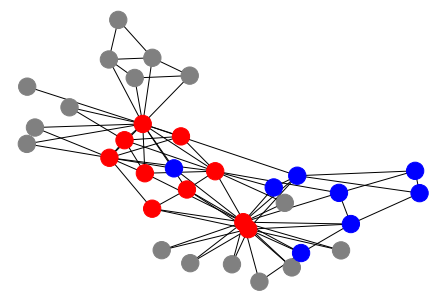

lambda = 1


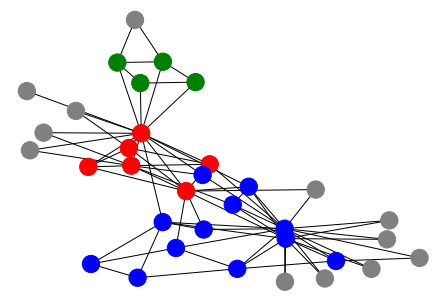

lambda = 5


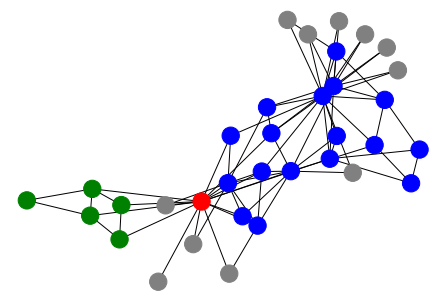

lambda = 10


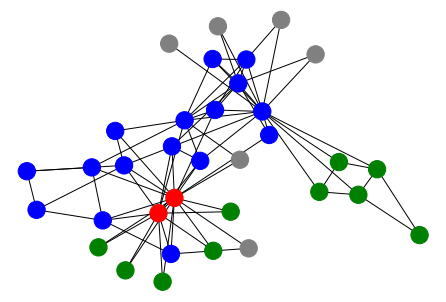

lambda = 50


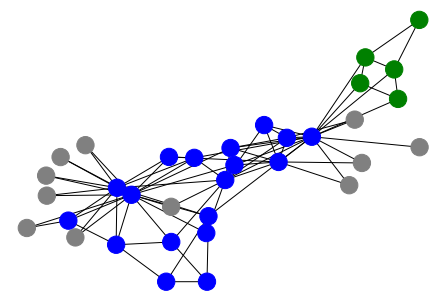

In [44]:
for lambd in [0.1,1,5,10, 50]:
    print('lambda =', lambd)
    G = nx.karate_club_graph()
    result, found_set = flowless_from_graph(G, 2, lambd=lambd)
    cs = []
    for i in G.nodes():
        tmp_c = 'grey'
        if i in result[0]:
            tmp_c = 'b'
            if i in result[1]:
                tmp_c = 'r'
        elif i in result[1]:
            tmp_c = 'g'
        cs.append(tmp_c)
    nx.draw(G, node_color=cs)
    plt.show()

lambda = 0.1


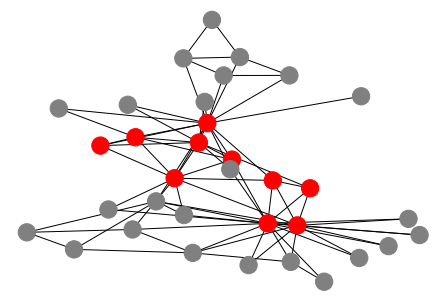

lambda = 1


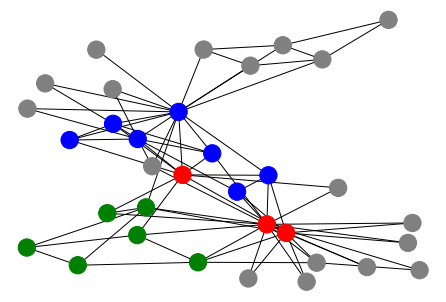

lambda = 5


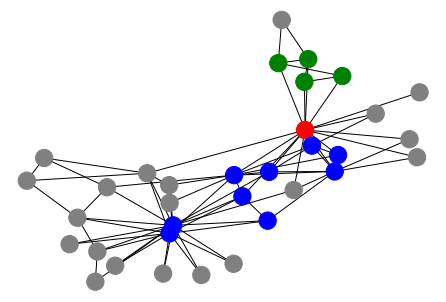

lambda = 10


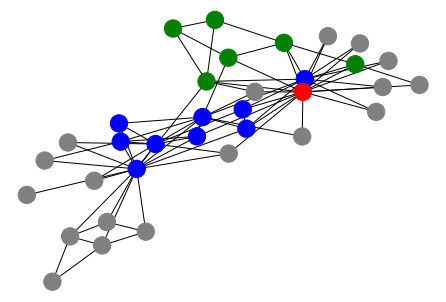

lambda = 50


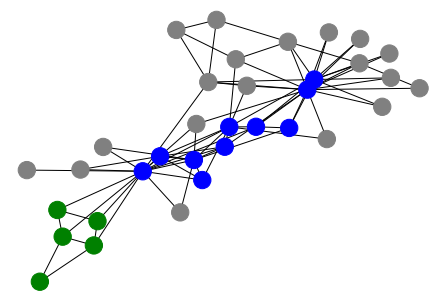

In [65]:
for lambd in [0.1,1,5,10, 50]:
    print('lambda =', lambd)
    G = nx.karate_club_graph()
    result, found_set = flowless_from_graph(G, 2, lambd=lambd, quasi_clique=True)
    cs = []
    for i in G.nodes():
        tmp_c = 'grey'
        if i in result[0]:
            tmp_c = 'b'
            if i in result[1]:
                tmp_c = 'r'
        elif i in result[1]:
            tmp_c = 'g'
        cs.append(tmp_c)
    nx.draw(G, node_color=cs)
    plt.show()